# Circadian Models 

> This notebook defines circadian models in a common framework

In [227]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
#| default_exp models

In [229]:
#| export 
import scipy as sp
from abc import ABC, abstractmethod
import numpy as np
from scipy.signal import find_peaks
from circadian.utils import phase_ic_guess

from ctypes import c_void_p, c_double, c_int, cdll
import scipy as sp
import pylab as plt
from pathlib import Path
import sys
from numba import jit, njit, prange



In [230]:
#| hide 

import time
from functools import wraps

def benchmark(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [231]:
#| hide
from nbdev.showdoc import *

In [232]:
#|export 

class DynamicalTrajectory:
    
    def __init__(self, 
                 ts: np.ndarray, # time points
                 states: np.ndarray # states at time points
                 ) -> None:
        self.ts = ts
        self.states = states
        
    def __call__(self, t: float) -> np.ndarray:
        return np.interp(t, self.ts, self.states)
    
    def __getitem__(self, idx: int) -> (float, np.ndarray):
        return self.ts[idx], self.states[idx]
    
    

In [233]:
# | export

class CircadianModel(ABC):

    def __init__(self, params: dict = None):
        pass

    @abstractmethod
    def _default_params(self):
        """
            Defines the default parameters for the model
        """
        pass

    def step_rk4(self,
                 state: np.ndarray,
                 light_val: float,
                 dt=0.10):
        """
            Return the state of the model assuming a constant light value
            for one time step and using rk4 to perform the step
        """
        k1 = self.derv(state, light=light_val)
        k2 = self.derv(state + k1 * dt / 2.0, light=light_val)
        k3 = self.derv(state + k2 * dt / 2.0, light=light_val)
        k4 = self.derv(state + k3 * dt, light=light_val)
        state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        return state

    def integrate_model(self,
                        ts: np.ndarray,  # Array of time points, also determines step size of RK4 solver
                        light_est: np.ndarray,  # Array of light estimates, should be the same length as ts
                        state: np.ndarray,  # Initial state of the model
                        ) -> DynamicalTrajectory:
        n = len(ts)
        sol = np.zeros((*state.shape, n))
        sol[..., 0] = state
        for idx in range(1, n):
            state = self.step_rk4(
                state=state,
                light_val=light_est[idx],
                dt=ts[idx]-ts[idx-1]
            )
            sol[..., idx] = state
        return DynamicalTrajectory(ts, sol)

    def dlmos(self, 
              trajectory: DynamicalTrajectory,  # solution from integrate_model
              ) -> np.ndarray: #array of times when the dlmo occurs for the model 
        """
            Finds the DLMO marker for the model
        """
        pass

    def cbt(self, 
            trajectory: DynamicalTrajectory,  # solution from integrate_model
            ) -> np.ndarray: # array of times when the cbt occurs
        """
            Finds the CBT minimum for the model
        """
        pass

    def observer(self,
                 trajectory: np.ndarray,  # solution from integrate_model
                 observer_func: callable,
                 ) -> np.array: # this will return the times when the observer func changes signs
        pass

    @staticmethod
    def amplitude(state: np.ndarray) -> float:
        """
            Gives the amplitude of the model at a given state
        """
        pass

    @staticmethod
    def phase(state: np.ndarray) -> float:
        """
            Gives the phase of the model at a given state
        """
        pass

    def default_initial_conditions(self):
        """
        Gives some default initial conditions for the model
        """
        pass

    def __call__(self,
                 ts: np.ndarray,  # Array of time points, also determines step size of RK4 solver
                 light_est: np.ndarray,  # Array of light estimates, should be the same length as ts
                 state: np.ndarray,  # Initial state of the model
                 *args,
                 **kwargs):
        return self.integrate_model(ts, light_est=light_est, state=state, *args, **kwargs)

    def initial_conditions_loop(self,
                                ts: np.ndarray, #Array of time points, also determines step size of RK4 solver
                                light_est: np.ndarray, #Array of light estimates, should be the same length as ts
                                num_loops: int = 30) -> np.ndarray: #Estimate the starting values by looping the given light_estimate
        
        ic = self.default_initial_conditions()
        for _ in range(num_loops):
            sol = self.integrate_model(ts, light_est, ic).states
            ic = sol[..., -1]
        return ic


## Forger VDP Based Model 

This model is taken from the [Forger et al 1999](https://journals.sagepub.com/doi/10.1177/074873099129000867). 

However, it uses the parameters taken from [Serkh et al 2014](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003523)rather than the parameters from the original paper.

This model provides a simplification of a series of models published in the 1990's based on modifications of the van der Pol nonlinear oscillator. It is one of the most popular models in the circadian literature. 

The model states are defined by three dynamic variables $(x, x_c, n)$. These states are related to circadian rhythms by defining the core body temperature minimum ( a biomarker for circadian state) to be the minimum of the $x$ variable. 



In [234]:
#| export

class Forger99Model(CircadianModel):
    """ A simple python implementation of the two population human model from Hannay et al 2019"""

    def __init__(self, params: dict= None):
        """
        Create a Forger VDP model 

        This will create a model with the default parameter values as given in Hannay et al 2019.

        This class can be used to simulate and plot the results of the given light schedule on the circadian phase
        and amplitude.
        """

        # Set the parameters to the published values by default
        self._default_params()
        
        if params:
            self.set_parameters(params)
        
        
    def _default_params(self):
        """
            Use the default parameters as defined in Hannay et al 2019
        """
        
        default_params = {'taux': 24.2,
                          'mu': 0.23,
                          'G': 33.75, 
                          'alpha_0': 0.05, 
                          'delta': 0.0075,
                          'p': 0.50, 
                          'I0': 9500.0, 
                          'kparam': 0.55}

        self.set_parameters(default_params)
        
    def set_parameters(self, param_dict: dict):
        """
            Update the model parameters using a passed in parameter dictionary. Any parameters not included
            in the dictionary will be set to the default values.

            updateParameters(param_dict)

            Returns null, changes the parameters stored in the class instance
        """
        

        params = [
            'taux',
            'mu'
            'G',
            'alpha_0',
            'delta',
            'p',
            'I0', 
            'kparam']

        for key, value in param_dict.items():
            setattr(self, key, value)
            
    def get_parameters_array(self):
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.taux, 
                         self.mu, 
                         self.G, 
                         self.alpha_0, 
                         self.delta, 
                         self.p, 
                         self.I0, 
                         self.kparam ])


    def get_parameters(self):
        """Get a dictionary of the current parameters being used by the model object.

        getParameters()

        returns a dict of parameters
        """

        current_params = {
            'taux': self.taux,
            'mu': self.mu,
            'G': self.G,
            'alpha_0': self.alpha_0,
            'delta': self.delta,
            'p': self.p,
            'I0': self.I0, 
            'kparam': self.kparam}

        return (current_params)

    def alpha0(self, 
               light: float # the light value in lux
               ):
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow((light / self.I0), self.p))

    def derv(self, 
             y: np.ndarray, # dynamical state 
             light: float # light value in lux
             ) -> np.ndarray: # This defines the ode system for the forger 99 model

        x = y[...,0]
        xc = y[...,1]
        n = y[...,2]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light) * \
            (1 - 0.4 * x) * (1 - 0.4 * xc)

        dydt = np.zeros_like(y)
        dydt[...,0] = np.pi / 12.0 * (xc + Bhat)
        dydt[...,1] = np.pi / 12.0 * (self.mu * (xc - 4.0 / 3.0 * pow(xc, 3.0)) - x * (
            pow(24.0 / (0.99669 * self.taux), 2.0) + self.kparam * Bhat))
        dydt[...,2] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)

        return (dydt)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        cbt_mins = find_peaks(-1*trajectory.states[0,:])[0] # min of x is the CBTmin
        return trajectory.ts[cbt_mins]
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.cbt(trajectory) - 7.0 # dlmo is defines by a relationship to cbt for this model

    def amplitude(state) -> float:
        return np.sqrt(state[0]**2+state[1]**2)

    def phase(state) -> float:
        x= state[0] 
        y = state[1]*-1.0
        return np.angle(x + complex(0,1)*y)
        
    def default_initial_conditions(self) -> np.ndarray:
        """
        x= –0.3 and xc= –1.13 are the default initial conditions for the model
        should be the value near the habitual bed time of the individual. 
        """
        return np.array([-0.3,-1.13,0.0])
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def __str__(self) -> str:
        return "Forger99Model"
        
    
    @staticmethod
    def guessICDataForger99(time_zero, lengh):
        """Guess the Initial conditions for the model using the persons light schedule
        Need to add a check to see if the system is entrained at all
        """
        pass
    

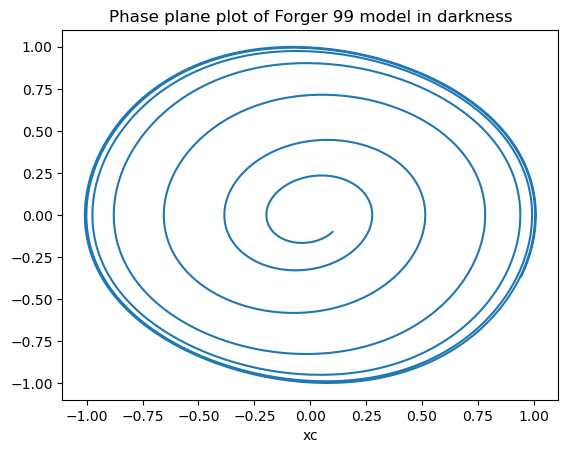

In [235]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99Model()

trajectory = fmodel.integrate_model(ts, 
                             light_values, 
                             state=np.array([0.10,-0.10,0.0]))



plt.plot(trajectory.states[0,:], trajectory.states[1,:])
plt.title("Phase plane plot of Forger 99 model in darkness")
plt.xlabel("x")
plt.xlabel("xc");


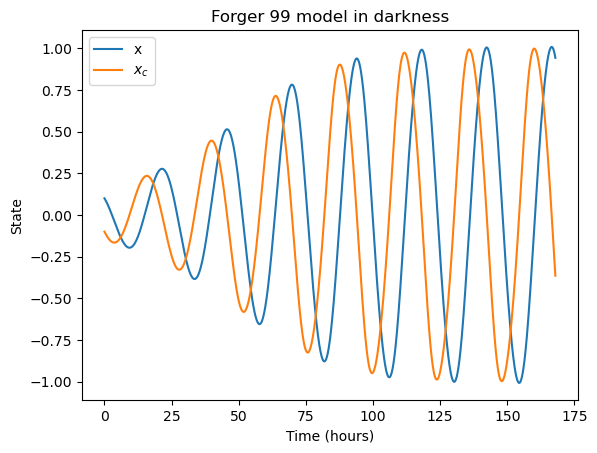

In [236]:
# Integrate observer for the Forger 99 model

plt.plot(trajectory.ts, trajectory.states[0,:], label="x")
plt.plot(trajectory.ts, trajectory.states[1,:], label="$x_c$")
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Forger 99 model in darkness")
plt.legend()
plt.show();

We can also run a the model for a whole collection of initial conditions in one pass by just adding a batch dimension to the initial state. 
Here we show how to run the Forger model for 100 random initial conditions centered on an initial estimate. 

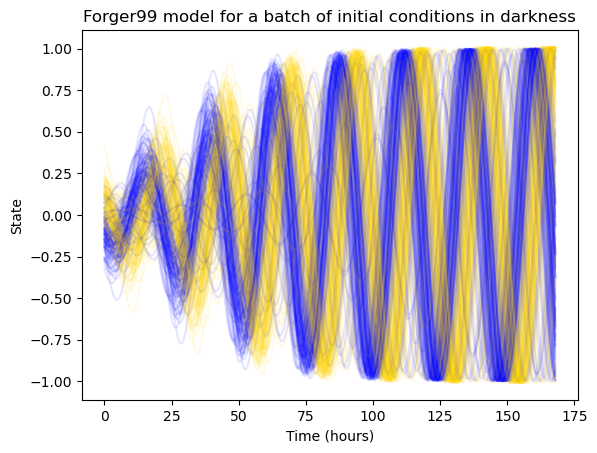

In [237]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99Model()

initial_conditions_batch = np.array([0.10,-0.10,0.0]) + np.random.normal(0, 0.1, (100,3))

trajectory = fmodel.integrate_model(ts, 
                             light_values, 
                             state=initial_conditions_batch)

for i in range(100):
    plt.plot(trajectory.ts, trajectory.states[i,1,:], color='blue', alpha=0.1)
    plt.plot(trajectory.ts, trajectory.states[i,0,:], color='gold', alpha=0.1)
plt.xlabel("Time (hours)")
plt.ylabel("State")
plt.title("Forger99 model for a batch of initial conditions in darkness")
plt.show();


Because adding a batch dimension is just using larger numpy arrays with the same vectorized operations under the hood we can run fairly larg batches with very little performance cost

In [238]:

@benchmark
def batched_run(batch_size: int):
    initial_conditions_batch = np.array([0.10,-0.10,0.0]) + np.random.normal(0, 0.1, (batch_size,3))
    sol = fmodel.integrate_model(ts, 
                             light_values, 
                             state=initial_conditions_batch)

for i in [1,10,100,500,1000, 5000]:
    batched_run(i)

Function batched_run(1,) {} Took 0.1168 seconds
Function batched_run(10,) {} Took 0.1110 seconds
Function batched_run(100,) {} Took 0.1263 seconds
Function batched_run(500,) {} Took 0.1950 seconds
Function batched_run(1000,) {} Took 0.2719 seconds
Function batched_run(5000,) {} Took 0.9517 seconds


We can also easily get predictions of the Dim Light Melatonin Onset (DLMO) and Core Body Temperature minimum (CBT). The time between these markers gives the period of the oscillator over that time frame. 



In [239]:
ts = np.arange(0, 24*7, 0.1)
light_values = np.zeros_like(ts) 
fmodel = Forger99Model()

trajectory = fmodel.integrate_model(ts, 
                             light_values, 
                             state=np.array([0.10,-0.10,0.0]))

cbt = fmodel.cbt(trajectory)
dlmos = fmodel.dlmos(trajectory)

print(f"Hours between CBTs: {np.diff(cbt)}")
print(f"Hours between DLMOs: {np.diff(dlmos)}")


Hours between CBTs: [24.3 24.1 24.2 24.1 24.2 24.2]
Hours between DLMOs: [24.3 24.1 24.2 24.1 24.2 24.2]


The values away from 24.2 give the period while the transients die away from the initial conditions, you can see that the *freerunning* period (period with no light time cues) is 24.2 which roughly matches the average value from experimental studies. 

We can adjust this by passing in a custom parameter for $\tau_x$ (taux)


In [240]:
fmodel_short_period = Forger99Model({ 'taux': 23.8})

trajectory = fmodel_short_period.integrate_model(ts,light_est=light_values, state=np.array([0.10,-0.10,0.0]))

dlmos = fmodel_short_period.dlmos(trajectory)
cbt = fmodel_short_period.cbt(trajectory)

print(f"Hours between DLMOs: {np.diff(dlmos)}")
print(f"Hours between CBTs: {np.diff(cbt)}")


Hours between DLMOs: [23.8 23.8 23.7 23.8 23.8 23.8]
Hours between CBTs: [23.8 23.8 23.7 23.8 23.8 23.8]


## Two Population Model

This file defines the two population model from the [Hannay et al 2019](https://journals.sagepub.com/doi/10.1177/0748730419878298). 

This model defines 
Here are some marker states for that model (all equals should be read as approx)

Biomarkers:
* CBT=DLMO+7hrs
* CBT=DLMO_mid+2hrs
* CBT=circadian phase pi in the model
* DLMO=circadian phase 5pi/12=1.309 in the model
* MelatoninOffset=DLMO+10hrs

Note, this model rotates counterclockwise in accordance with the usual convention
in mathematics. The VDP family of models rotate clockwise. This can be confusing when trying
to compare phase plane plots between the models, but is fixable with a simple rotation.

An effort will be made to have the core methods align between all of the models implemented
in this package.


In [241]:
#| export

class TwoPopulationModel(CircadianModel):
    """ A simple python implementation of the two population human model from Hannay et al 2019"""

    def __init__(self, params: dict= None):
        # Set the parameters to the published values by default
        self._default_params()
        if params:
            self.set_parameters(params)
        
    def _default_params(self):
        """
            Use the default parameters as defined in Hannay et al 2019
        """
        
        default_params = {'tauV': 24.25,
                          'tauD': 24.0,
                          'Kvv': 0.05, 
                          'Kdd': 0.04,
                          'Kvd': 0.05,
                          'Kdv': 0.01,
                          'gamma': 0.024,
                          'A1': 0.440068, 
                          'A2': 0.159136,
                          'BetaL': 0.06452, 
                          'BetaL2': -1.38935, 
                          'sigma': 0.0477375,
                          'G': 33.75, 
                          'alpha_0': 0.05, 
                          'delta': 0.0075,
                          'p': 1.5, 
                          'I0': 9325.0}

        self.set_parameters(default_params)
        
    def set_parameters(self, param_dict: dict):
        """
            Update the model parameters using a passed in parameter dictionary. Any parameters not included
            in the dictionary will be set to the default values.

            updateParameters(param_dict)

            Returns null, changes the parameters stored in the class instance
        """
        

        params = [
            'tauV',
            'tauD',
            'Kvv',
            'Kdd',
            "Kvd",
            "Kdv",
            'gamma',
            'A1',
            'A2',
            'BetaL',
            'BetaL2',
            'sigma',
            'G',
            'alpha_0',
            'delta',
            'p',
            'I0']

        for key, value in param_dict.items():
            setattr(self, key, value)
            
    def get_parameters_array(self):
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.tauV, self.tauD, self.Kvv, self.Kdd, self.Kvd, self.Kdv, self.gamma, self.BetaL, self.BetaL2, self.A1, self.A2, self.sigma, self.G, self.alpha_0, self.delta, self.p, self.I0 ])


    def get_parameters(self):
        """Get a dictionary of the current parameters being used by the model object.

        getParameters()

        returns a dict of parameters
        """

        current_params = {
            'tauV': self.w0,
            'tauD': self.tauD,
            'Kvv': self.Kvv,
            'Kdd': self.Kdd,
            'Kdv': self.Kdv,
            'Kvd': self.Kdv,
            'gamma': self.gamma,
            'A1': self.A1,
            'A2': self.A2,
            'BetaL': self.BetaL,
            'BetaL2': self.BetaL2,
            'sigma': self.sigma,
            'G': self.G,
            'alpha_0': self.alpha_0,
            'delta': self.delta,
            'p': self.p,
            'I0': self.I0}

        return (current_params)

    def alpha0(self, light: float):
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow(light, self.p) /
                (pow(light, self.p) + self.I0))

    def derv(self, 
             y: np.ndarray, 
             light: float) -> np.ndarray:

        Rv = y[...,0]
        Rd = y[...,1]
        Psiv = y[...,2]
        Psid = y[...,3]
        n = y[...,4]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light)

        LightAmp = self.A1 * 0.5 * Bhat * (1.0 - pow(Rv, 4.0)) * np.cos(Psiv + self.BetaL) + self.A2 * 0.5 * Bhat * Rv * (
            1.0 - pow(Rv, 8.0)) * np.cos(2.0 * Psiv + self.BetaL2)
        LightPhase = self.sigma * Bhat - self.A1 * Bhat * 0.5 * (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(
            Psiv + self.BetaL) - self.A2 * Bhat * 0.5 * (1.0 + pow(Rv, 8.0)) * np.sin(2.0 * Psiv + self.BetaL2)

        dydt = np.zeros_like(y)
        dydt[...,0] = -self.gamma * Rv + self.Kvv / 2.0 * Rv * (1 - pow(Rv, 4.0)) + self.Kdv / 2.0 * Rd * (
            1 - pow(Rv, 4.0)) * np.cos(Psid - Psiv) + LightAmp
        dydt[...,1] = -self.gamma * Rd + self.Kdd / 2.0 * Rd * \
            (1 - pow(Rd, 4.0)) + self.Kvd / 2.0 * Rv * (1.0 - pow(Rd, 4.0)) * np.cos(Psid - Psiv)
        dydt[...,2] = 2.0 * np.pi / self.tauV + self.Kdv / 2.0 * Rd * \
            (pow(Rv, 3.0) + 1.0 / Rv) * np.sin(Psid - Psiv) + LightPhase
        dydt[...,3] = 2.0 * np.pi / self.tauD - self.Kvd / 2.0 * \
            Rv * (pow(Rd, 3.0) + 1.0 / Rd) * np.sin(Psid - Psiv)
        dydt[...,4] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)
        return dydt
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, TwoPopulationModel.DLMOObs)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, TwoPopulationModel.CBTObs)

    def observer(self, trajectory: np.ndarray, observer_func: callable) -> np.array:
        zero_crossings = np.where(np.diff(np.sign(observer_func(0.0, trajectory.states))))[0]
        return trajectory.ts[zero_crossings]

    def DLMOObs(t, state) -> float:
        return np.sin(0.5*(TwoPopulationModel.phase(state)-5*np.pi/12.0))
    
    def CBTObs(t, state) -> float:
        return np.sin(0.5*(TwoPopulationModel.phase(state)-np.pi))

    def amplitude(state):
        # Make this joint amplitude at some point 
        return(state[0])

    def phase(state):
        return(state[2])
    
    @staticmethod
    def phase_difference(state):
        return state[2] - state[3]
    
    def default_initial_conditions(self):
        return np.array([1.0,1.0,0.0,0.10,0.0])
    
    @staticmethod
    def guessICDataTwoPop(time_zero, length=150):
        """Guess the Initial conditions for the model using the persons light schedule
        Need to add a check to see if the system is entrained at all
        """
        pass




## Single Population Model (Hannay 2019)

This file defines the single population model from the paper:

Hannay, K. M., Booth, V., & Forger, D. B. (2019). Macroscopic Models for Human Circadian Rhythms.
Journal of Biological Rhythms, 34(6), 658–671. https://doi.org/10.1177/0748730419878298

Here are some marker states for that model (all equals should be read as approx)

CBT=DLMO+7hrs
CBT=DLMO_mid+2hrs
CBT=circadian phase pi in the model
DLMO=circadian phase 5pi/12=1.309 in the model
MelatoninOffset=DLMO+10hrs

Note, this model rotates counterclockwise in accordance with the usual convention
in mathematics. The VDP family of models rotate clockwise. This can be confusing when trying
to compare phase plane plots between the models, but is fixable with a simple rotation.

An effort will be made to have the core methods align between all of the models implemented
in this package.


In [242]:
#| export

class SinglePopModel(CircadianModel):
    """
        A simple python program to integrate the human circadian rhythms model 
        (Hannay et al 2019) for a given light schedule
    """

    def __init__(self, params: dict = None):
        """
            Create a single population model by passing in a Light Function as a function of time.

            This will create a model with the default parameter values as given in Hannay et al 2019.

            This class can be used to simulate and plot the results of the given light schedule on the circadian phase
            and amplitude.
        """
        self._default_params()
        if params:
            self.set_parameters(params)

    def _default_params(self):
        """
            Use the default parameters as defined in Hannay et al 2019
        """
        default_params = {'tau': 23.84, 'K': 0.06358, 'gamma': 0.024,
                          'Beta1': -0.09318, 'A1': 0.3855, 'A2': 0.1977,
                          'BetaL1': -0.0026, 'BetaL2': -0.957756, 'sigma': 0.0400692,
                          'G': 33.75, 'alpha_0': 0.05, 'delta': 0.0075,
                          'p': 1.5, 'I0': 9325.0}

        self.set_parameters(default_params)

    def set_parameters(self, param_dict: dict):
        """
            Update the model parameters using a passed in parameter dictionary. Any parameters not included
            in the dictionary will be set to the default values.

            updateParameters(param_dict)

            Returns null, changes the parameters stored in the class instance
        """

        params = ['tau', 'K', 'gamma', 'Beta1', 'A1', 'A2', 'BetaL1',
                  'BetaL2', 'sigma', 'G', 'alpha_0', 'delta', 'p', 'I0']

        for key, value in param_dict.items():
            setattr(self, key, value)

    def get_parameters(self):
        """
            Get a dictionary of the current parameters being used by the model object.

                get_parameters()

            returns a dict of parameters
        """

        current_params = {'tau': self.tau, 'K': self.K, 'gamma': self.gamma,
                          'Beta1': self.Beta1, 'A1': self.A1, 'A2': self.A2,
                          'BetaL1': self.BetaL1,
                          'BetaL2': self.BetaL2, 'sigma': self.sigma,
                          'G': self.G, 'alpha_0': self.alpha_0,
                          'delta': self.delta, 'p': self.p, 'I0': self.I0}

        return(current_params)

    def get_parameters_array(self):
        """
            Return a numpy array of the models current parameters
        """
        return np.array([self.tau, self.K, self.gamma, self.Beta1, self.A1, self.A2, self.BetaL1, self.BetaL2, self.sigma, self.G, self.alpha_0, self.delta, self.I0, self.p])
    
    def alpha0(self, light: float):
        """A helper function for modeling the light input processing"""
        return (self.alpha_0 * pow(light, self.p) /
                (pow(light, self.p) + self.I0))
    
    def derv(self, 
             y: np.ndarray, # circadian state where the last dimension is the state variable
             light: float, # light level in lux 
             ):
        R = y[...,0]
        Psi = y[..., 1]
        n = y[...,2]

        Bhat = self.G * (1.0 - n) * self.alpha0(light=light)
        LightAmp = self.A1 * 0.5 * Bhat * (1.0 - pow(R, 4.0)) * np.cos(Psi + self.BetaL1) + self.A2 * 0.5 * Bhat * R * (
            1.0 - pow(R, 8.0)) * np.cos(2.0 * Psi + self.BetaL2)
        LightPhase = self.sigma * Bhat - self.A1 * Bhat * 0.5 * (pow(R, 3.0) + 1.0 / R) * np.sin(
            Psi + self.BetaL1) - self.A2 * Bhat * 0.5 * (1.0 + pow(R, 8.0)) * np.sin(2.0 * Psi + self.BetaL2)

        dydt = np.zeros_like(y)
        dydt[...,0] = -1.0 * self.gamma * R + self.K * \
            np.cos(self.Beta1) / 2.0 * R * (1.0 - pow(R, 4.0)) + LightAmp
        dydt[...,1] = 2*np.pi/self.tau + self.K / 2.0 * \
            np.sin(self.Beta1) * (1 + pow(R, 4.0)) + LightPhase
        dydt[...,2] = 60.0 * (self.alpha0(light=light) * (1.0 - n) - self.delta * n)

        return (dydt)

    # def integrate_model(self,
    #                     ts: np.ndarray,
    #                     light_est: np.ndarray,
    #                     state: np.ndarray = None):
    #     """
    #         Integrate the spmodel forward in time using the given light estimate vector
    #     """
    #     params = self.get_parameters_array()
    #     n = len(ts)
    #     sol = np.zeros((n, 3))
    #     fastclock.integrate_spmodel_save(
    #         c_void_p(sol.ctypes.data),
    #         c_void_p(state.ctypes.data),
    #         c_void_p(ts.ctypes.data),
    #         c_void_p(light_est.ctypes.data),
    #         c_void_p(params.ctypes.data),
    #         c_int(n))
    #     return(np.transpose(sol))
        

    def integrate_observer(self, ts: np.ndarray, light_est: np.ndarray, u0: np.ndarray = None, observer=None):
        """
            Integrate the spmodel forward in time using the given light estimate vector
        """
        if observer is None:
            observer = SinglePopModel.DLMOObs
        sol = self.integrate_model(ts, light_est, u0)
        zero_crossings = np.where(np.diff(np.sign(observer(0.0, sol))))[0]
        return ts[zero_crossings]
    
    def dlmos(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, SinglePopModel.DLMOObs)
    
    def cbt(self, trajectory: DynamicalTrajectory) -> np.ndarray:
        return self.observer(trajectory, SinglePopModel.CBTObs)

    def observer(self, trajectory: np.ndarray, observer_func: callable) -> np.array:
        zero_crossings = np.where(np.diff(np.sign(observer_func(0.0, trajectory.states))))[0]
        return trajectory.ts[zero_crossings]

    def DLMOObs(t, state) -> float:
        return np.sin(0.5*(SinglePopModel.phase(state)-5*np.pi/12.0))
    
    def CBTObs(t, state) -> float:
        return np.sin(0.5*(SinglePopModel.phase(state)-np.pi))

    def amplitude(state) -> float:
        return(state[0])

    def phase(state) -> float:
        return(state[1])
    
    def default_initial_conditions(self) -> np.ndarray:
        """
        Gives some default initial conditions for the model
        """
        return np.array([0.70,0.0,0.0])


Text(0.5, 0, 'R sin(Psi)')

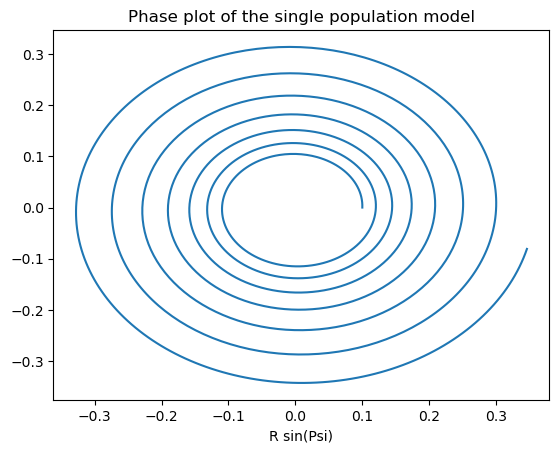

In [243]:
spmodel = SinglePopModel()

ts = np.arange(0, 24*7, 0.10)
light_values = np.zeros(len(ts))
trajectory= spmodel.integrate_model(ts, light_values, np.array([0.10, 0.0,0.0]))

plt.plot(trajectory.states[0,:]*np.cos(trajectory.states[1,:]), trajectory.states[0,:]*np.sin(trajectory.states[1,:]))
plt.title("Phase plot of the single population model")
plt.xlabel("R cos(Psi)")
plt.xlabel("R sin(Psi)")



Because of the way the integration code is written it is simple to run a collection of initial conditions through the model by just adding an batch dimension (terminology taken from the machine learning literature). This shows an example of running the model through 

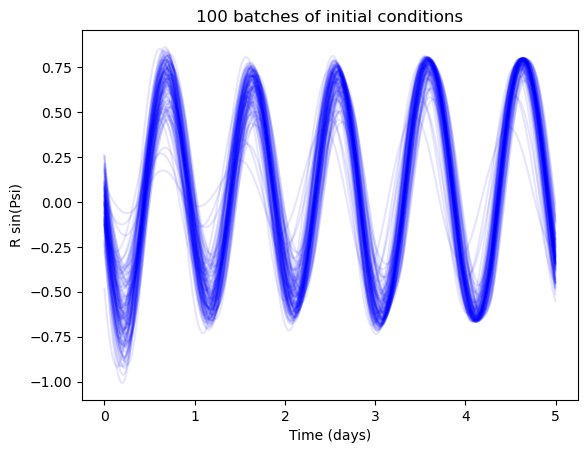

In [244]:
from circadian.lights import *  

spmodel = SinglePopModel()

ts = np.arange(0, 24*5, 0.10)
light_func = Light.ShiftWorkLight(dayson=3, daysoff=4)
light_values = light_func(ts)
num_batches = 100
initial_conditions_batch = np.array([0.70, np.pi,0.0]) + np.random.randn(num_batches,3)*0.20

trajectory = spmodel.integrate_model(ts, light_values, initial_conditions_batch)
for batch_idx in range(num_batches):
    plt.plot(trajectory.ts / 24.0, trajectory.states[batch_idx, 0,:]*np.sin(trajectory.states[batch_idx,1,:]), color='blue', alpha=0.10)
plt.title(f"{num_batches} batches of initial conditions")
plt.xlabel("Time (days)")
plt.ylabel("R sin(Psi)");


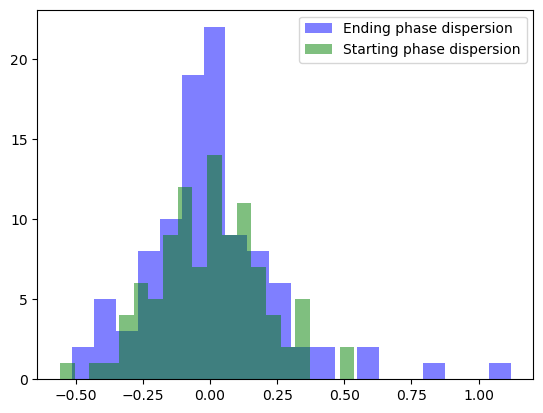

In [245]:

plt.hist((trajectory.states[:,1,-1] - np.mean(trajectory.states[:,1,-1])) , bins=20, color='blue', alpha=0.5, label="Ending phase dispersion");
plt.hist((trajectory.states[:,1,0] - np.mean(trajectory.states[:,1,0])) , bins=20, color='green', alpha=0.5, label="Starting phase dispersion");
plt.legend();


## Models Coming Soon

## Non Photic Model ( Hilaire 2007) 

This implements the model from [Hilaire et al 2007](https://pubmed.ncbi.nlm.nih.gov/17531270/) 


```{javascript}
function clockModel_HilaireNonPhotic(t, y) {

    let index = Math.round(t / DELTA_T);

    let I = localLD[index];
    let sleepWakeStatus = localSW[index];
    
    let x = y[0];
    let xc = y[1];
    let n = y[2];

    let tx = 24.2;
    let G = 37;
    let k = .55;
    let mu = .13;
    let beta = 0.007;
    let q = 1/3;
    let rho = 0.032;

    let C = t % 24;
    let phi_xcx = -2.98;
    let phi_ref = 0.97;
    let CBTmin = phi_xcx + phi_ref;
    CBTmin = CBTmin*24/(2*Math.PI);
    let psi_cx = C - CBTmin;
    psi_cx = psi_cx % 24;

    let Bh = G * (1 - n) * alphNonPhotic(I);
    let B = Bh * (1 - .4 * x) * (1 - .4 * xc);

        // Subtract from 1 to make the sign work
    // From St. Hilaire (2007): sigma equals either 1 (for sleep/rest) or 0 (for wake/activity),
    let sigma = 1 - sleepWakeStatus;
    if (sigma < 1/2){
        sigma = 0;
    }
    else{
        sigma = 1;
    }

    let Nsh = rho*(1/3 - sigma);
    
    if (psi_cx > 16.5 && psi_cx < 21){
        Nsh = rho*(1/3);
    }else{
        Ns = Nsh*(1 - Math.tanh(10*x));
    }
        

    let dydt = [0, 0, 0];

    dydt[0] = Math.PI / 12.0 * (xc + mu*((1/3)*x + (4/3)*Math.pow(x,3.0) - 256/105*Math.pow(x,7.0)) + B + Ns);
    dydt[1] = Math.PI / 12.0 * (q*B*xc - x*(Math.pow((24/(0.99729*tx)),2) + k*B));
    dydt[2] = 60.0 * (alphNonPhotic(I) * (1.0 - n) - beta * n);
    
    return dydt;
}

```

In [246]:
class Hilaire2007(CircadianModel):
    pass # TODO
    

## Rea22 Model 

Check out this [model](https://pubmed.ncbi.nlm.nih.gov/36238087/) 



In [247]:
class Rea22(CircadianModel):
    pass # TODO



## Phase Dynamics Model Nakao02 

[model](https://pubmed.ncbi.nlm.nih.gov/12375623/)

In [248]:
#| hide
import nbdev; nbdev.nbdev_export()